# Multi-Modal Semantic, Lexical and Hybrid Search 

The following cell installs required python libraries specified in the 'requirements.txt' file.

In [1]:
#This cell installs the required libraries specified in the 'requirements.txt' file
!pip install -r requirements.txt --quiet


In [2]:
# load required libraries 
import os
import pandas as pd
import sagemaker
import boto3
import json
import pprint
import random 
from PIL import Image
from IPython.display import display
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers
import time

session = boto3.session.Session()
region_name = session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Load the utility library from the src folder which contains various functions for this notebook ease of use and simplicy. 

In [3]:
#adding our utils library to sys path
import sys
sys.path.append("./src/helpers/")
from utils import *

Before we begin conducting search let us reload the required datasets and variables from previous notebooks 

In [4]:
# load the dataset from notebook 2 
%store -r df_metadata
# df_metadata = pd.read_csv('./data/enriched_dataset.csv')
df_metadata.head()

image_id                                        path  \
0  00a7655d4eabf186.jpg  ./data/resized-images/00a7655d4eabf186.jpg   
1  19aa926f2f7d9782.jpg  ./data/resized-images/19aa926f2f7d9782.jpg   
2  39209fa476d1430c.jpg  ./data/resized-images/39209fa476d1430c.jpg   
3  1efc2db85591a04f.jpg  ./data/resized-images/1efc2db85591a04f.jpg   
4  3c06d149c8027e71.jpg  ./data/resized-images/3c06d149c8027e71.jpg   

                                   title  \
0  Baseball player batting during a game   
1  Baseball Player Batting During a Game   
2     Baseball Players Gathered on Field   
3          Baseball batter at home plate   
4          Youth Baseball Player Batting   

                                         description  \
0  The image depicts a baseball player in a batti...   
1  The image depicts a professional baseball play...   
2  The image depicts a group of baseball players ...   
3  The image depicts a baseball game in progress....   
4  The image depicts a young baseball player in a...   

                                            keywords  \
0  baseball, sports, batting, player, jersey, sta...   
1  baseball, sports, athlete, batting, swing, sta...   
2  baseball, players, team, field, uniforms, bats...   
3  baseball, batter, swing, pitch, catcher, field...   
4  baseball, youth sports, batting, swing, athlet...   

                                                tags  \
0     baseball, sports, athlete, action, competition   
1  baseball, sports, athlete, batting, stadium, g...   
2  sports, baseball, athletes, coaching, team gat...   
3       baseball, sports, game, athlete, competition   
4          sports, baseball, youth, athlete, batting   

                                          embeddings  
0  [0.041014045, 0.021385895, -0.02275303, 0.0187...  
1  [0.03466529, 0.02793032, -0.029118843, -0.0156...  
2  [0.031110628, 0.030195609, -0.060391217, -0.01...  
3  [0.047018528, 0.025594763, -0.030524123, 0.023...  
4  [0.011220759, 0.06612398, -0.048392408, -0.019...

In [5]:
# retrieve the index name and collection details for OSS from previous notebook
%store -r index_name
%store -r collection_name
%store -r host

print("opensearch host:{0}, index:{1}, collection:{2}".format(host, index_name, collection_name))

opensearch host:d2ajgamr8oz8ts81k02d.us-east-1.aoss.amazonaws.com, index:smart-search-index-faiss, collection:media-search-833


## Preparing the OSS Client

This section demonstrates how to search the index using vector embeddings and the k-nearest neighbors (KNN) algorithm as well as conduct classic lexical search in OSS. It generates an embedding for a given query text as well as a reference image, constructs a KNN query, and retrieves the top k most relevant documents from the index.


Before we can query, we first need to build a client using the opensearch library. The following cell builds a client using the current users credentials as well as the host name we saved in previous notebook. 

In [6]:
# create the collection of type vector search
oss_client = boto3.client('opensearchserverless')
# create the OSS client
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)


# Build the OpenSearch client
search_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)

## Search the index 

In this section, we will be conducting various styles of searches with opensearch from classic Lexical search using keywords and query matching, to more advanced vector search using the KNN algorithm as well as hybrid searches. 

Nearest neighbor search is conducted by simply measuring the distance between vectors. There are different distance metrics used in vector similarity calculations such as:
Euclidean distance: It measures the straight-line distance between two vectors in a vector space. It ranges from 0 to infinity, where 0 represents identical vectors, and larger values represent increasingly dissimilar vectors.

Cosine distance: This similarity measure calculates the cosine of the angle between two vectors in a vector space. It ranges from -1 to 1, where 1 represents identical vectors, 0 represents orthogonal vectors, and -1 represents vectors that are diametrically opposed.

Dot product: This measure reflects the product of the magnitudes of two vectors and the cosine of the angle between them. Its range extends from -∞ to ∞, with a positive value indicating vectors that point in the same direction, 0 indicating orthogonal vectors, and a negative value indicating vectors that point in opposite directions.

![Alt text](./static/distance.png "Distance metrics")

k-NN or rather approximate Nearest Neighbor (ANN) is the foundation for conducting similary search in OpenSearch and it is supported by nmslib, faiss, and Lucene libraries. Each of the three engines used for approximate k-NN search has its own attributes that make one more sensible to use than the others in a given situation. You can follow the general information below to help determine which engine will best meet your requirements.

k-NN for Amazon OpenSearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance or cosine similarity. 

In general, nmslib outperforms both faiss and Lucene on search. However, to optimize for indexing throughput, faiss is a good option. For relatively smaller datasets (up to a few million vectors), the Lucene engine demonstrates better latencies and recall. At the same time, the size of the index is smallest compared to the other engines, which allows it to use smaller AWS instances for data nodes.

Overall, for larger data sets, you should generally choose the approximate nearest neighbor method because it scales significantly better.

The purpose is to provide a clear indication of the varying output when text vector are used over direct image embeddings. 

### OSS DSL queries
The code cell below builds a opensearch DSL queries payload before calling opensearch via the search client. 

Two functions are defined here to conduct lexical as well as embeddings search using the KNN algorithm in opensearch. For the similarity search using embeddings it requires an additoinal k parameter to find k number of nearest neighbors from the vector space. In literal terms this will find k number of similar items that are closest to the input emebeddings in euclidean distance. Opensearch directly does this evaluation therefore we only need to specify the number of neighbors. 

In [7]:
# helper functions to conduct lexical, vector similarity, as well as hybrid style vector and filter search

def query_text_description(search_term, hits=10):
    query = {
        "query": {
            "match": {
                "title": {
                    "query": search_term
                }
            }
        },
        "_source": {
            "exclude": ["image_vector"], # exclude vectors from the response
        },
        "size": hits
    }
    
    search_response = search_client.search(body=query, index=index_name)
    return search_response

def query_similarity(query_emb, hits=10, k=5):
    
    body = {
            "query": {
                "knn": {
                    "image_vector": {
                        "vector": query_emb,
                        "k": k,
                    }
                }
            },
            "_source": {
                "exclude": ["image_vector"],
            },
            "size": hits
    }     

    search_response = search_client.search(index=index_name, body=body)
    return search_response

def query_similarity_filter(query_emb, filter_text, hits=10, k=5):
    body = {
            "query": {
                "knn": {
                    "image_vector": {
                        "vector": query_emb,
                        "k": k,
                        "filter": {
                            "bool": {
                                "must": [
                                    {
                                        "multi_match": {
                                          "query": filter_text,
                                          "fields": [
                                            "title", "keywords", "tags", "description"
                                          ]
                                        }
                                      }
                                ]
                            }
                        }
                    }
                }
            },
            #"post_filter": {
            #    "match": {
            #        "description": "rugby player wearing red shirt"
            #    }
            #},
            "_source": {
                "exclude": ["image_vector"],
            },
            "size": hits
    }

    search_response = search_client.search(index=index_name, body=body)
    return search_response

In [8]:
#  set the search term 
search_term = "baseball player swinging bat"

### Lexical search 

The cell below utilises a utility function to display results as images from the util library by mapping the file name in our dataset and locating the path. This is done to keep the notebook less verbose. For subsequent scenarios where image previous are required from search results we are going to be utilising the same utility function. 

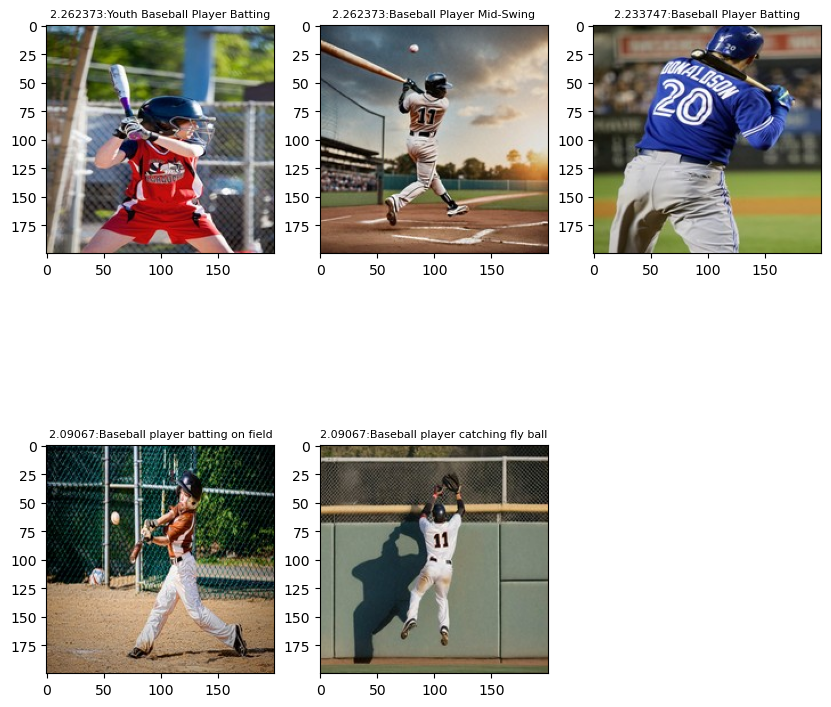

In [9]:
results_lexical = query_text_description(search_term, 5)
display_results(results_lexical, df_metadata)

In [10]:
# reload 
%load_ext autoreload
%autoreload 2
from utils import *

### Semantic search using text embeddings

In this section we will conduct the same search but this time utilise the titan text embeddings to convert the search term into vector embeddings and conduct a vector search using the KNN algorithm. 

Since the query term needs to be converted to a vector first, we will call a method in the utility library which in turn calls titan multi-modal embedding model to generate the query embeddings.

Note: For this search to be functional we are required to call the same embeddings model that is used for the image embeddings task. In data enrichment notebook, we utilised Titan Multimodal Embeddings G1 model and will be using the same for query embeddings. 


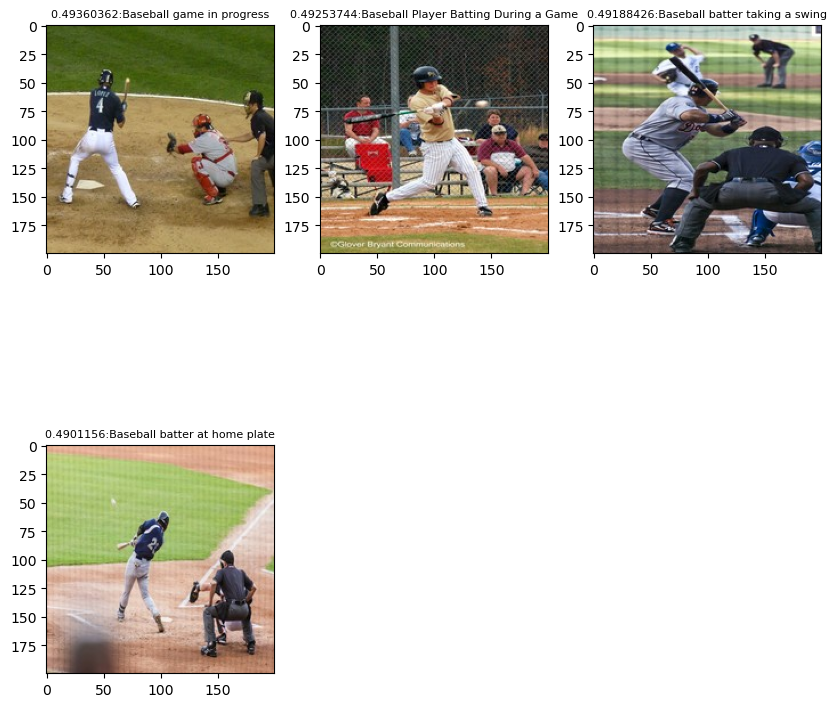

In [11]:
query_emb = get_titan_multimodal_embedding(description=search_term, dimension=1024)["embedding"]
results_semantic_text = query_similarity(query_emb, hits=5, k=2)
display_results(results_semantic_text, df_metadata)

### Semantic search using Image embeddings

In order for the search to take into account finder semantic meanings we can utilise a reference image as well as text for query embeddings. This will allow specific properties of hte image to be embedded into the vector space therefore return a tighter result set. 


The following cell generates a base image using titan image generator for the purpose of search 


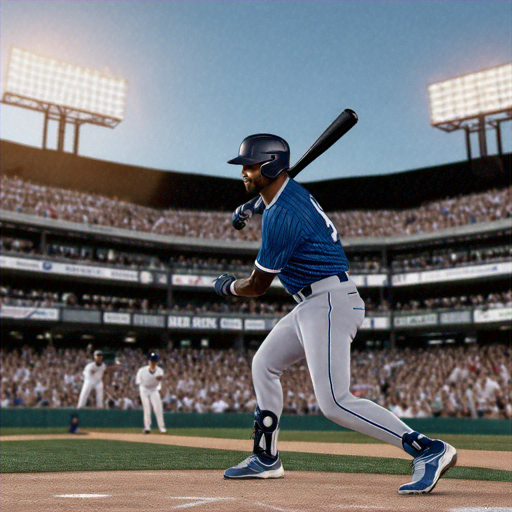

In [12]:
prompt = "ultra photorealistic professional baseball player blue jersey about to hit a home run, ballfield, spectators"
neg_prompt = "blurry, low quality, distorted"
test_img = generate_titan_image(prompt=prompt,neg_prompt=neg_prompt, seed=random.randint(1,9))
path = "./data/testimg.png"
test_img.save(path)
test_img

Use the test image as reference image to now conduct a similarity search. 

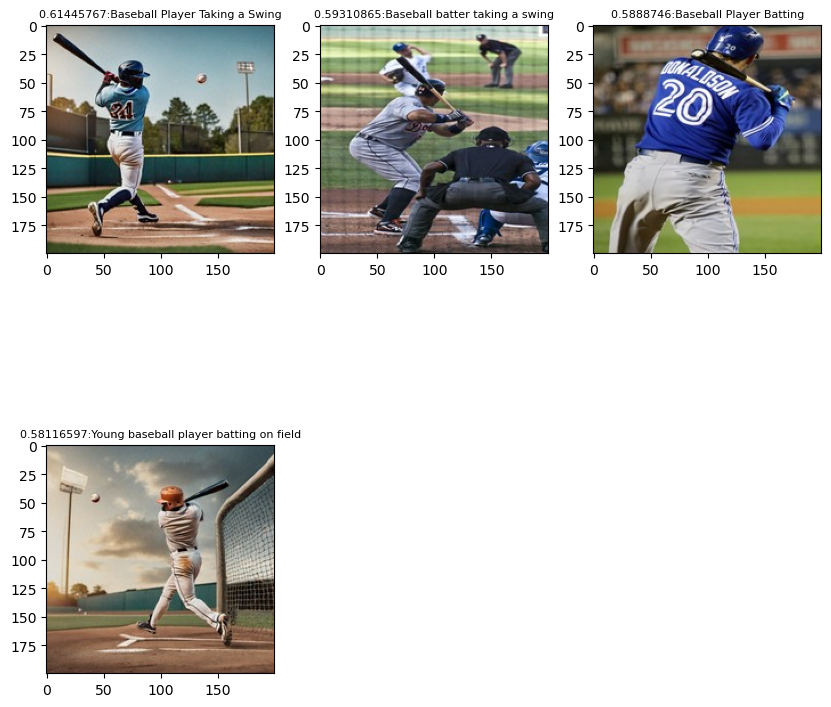

In [13]:
query_emb = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
results_semantic_img = query_similarity(query_emb, hits=5, k=2)
display_results(results_semantic_img, df_metadata)

Since titan embedding can take in both image and text, the following cell combines a user supplied term as well as a reference image. We are again utilising a util function to get a single embedding from the image and text. The embedding is them used to carry out a knn search. For this particular instance we are attempting to find a similar image but the action is "diving to catch the ball". 

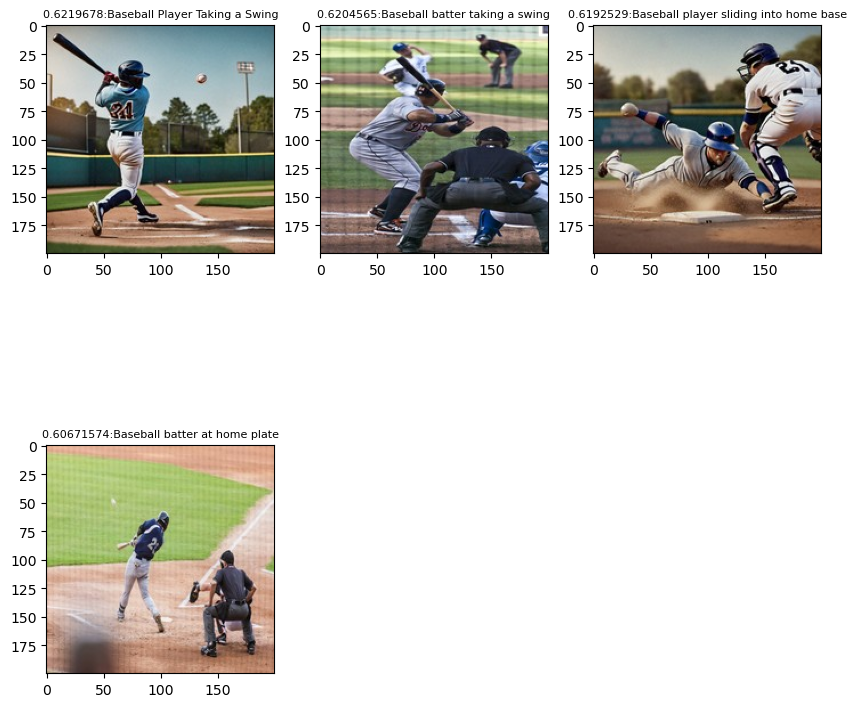

In [25]:
optional_description = "diving catch"
query_emb = get_titan_multimodal_embedding(image_path=path, description=optional_description, dimension=1024)["embedding"]
results_semantic_img_txt = query_similarity(query_emb, hits=10, k=2)
display_results(results_semantic_img_txt, df_metadata)

### Semantic search using generated description

For this step, we are going to extract text description of the image using Claude Sonnet which in turn will be used to carry out embeddings search. 

In [15]:
prompt = """
You are a multimodal search engine metadata extractor. Your task is to carefully study the image and generate a text description of the image.
Be detailed on various aspects of the image such as background, foreground, subject, and other finer details of the image.

Make necessary determination on the key category/theme of the image and generate description as appropriate. 

Description generated is required to be professional for official use. Refrain from using informal language. 

The intended audience are various business users who will attempt to search based on a description in natural language of what they are looking for.  

Output the description as plain text only. 
"""

In [16]:
res=generate_img_desc(prompt=prompt, img_path=path)
pprint.pp(res)

("The image depicts a professional baseball player standing at the batter's "
 'box on a baseball field. The player is wearing a navy blue uniform and '
 'batting helmet, holding a baseball bat in a ready stance. The stadium is '
 'filled with spectators in the stands, and large bright lights illuminate the '
 'field. The background shows the iconic outfield walls and scoreboards of a '
 'major league baseball stadium. The scene captures the intense atmosphere of '
 'a professional baseball game, with the batter poised to take his turn at the '
 'plate against the opposing pitcher.')


use the description of the image as the source text embedding.

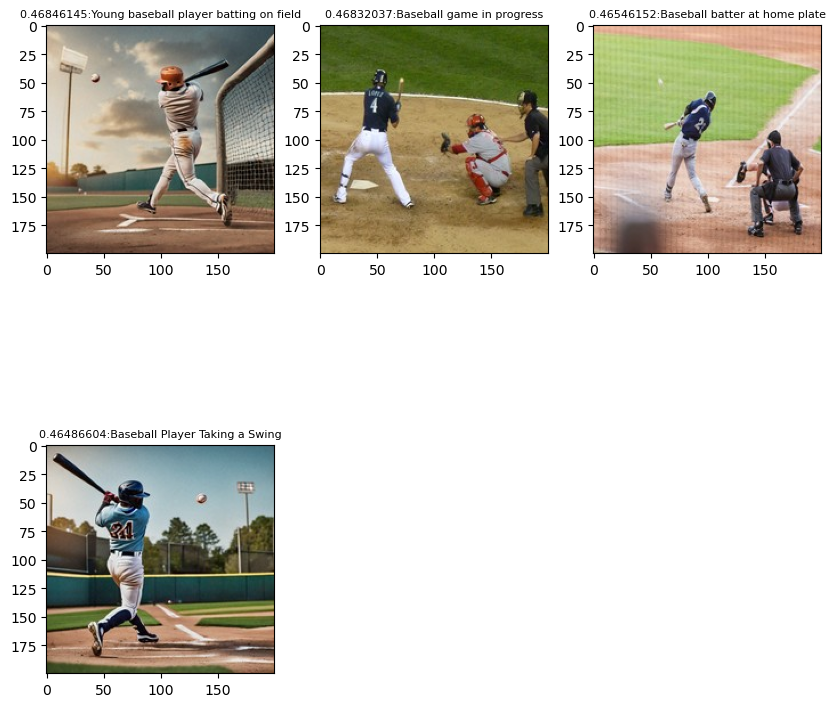

In [24]:
optional_description = "diving catch" # this can be user supplied text in addition to the image
search_term = res + optional_description
query_emb = get_titan_multimodal_embedding(description=search_term, dimension=1024)["embedding"]
results_semantic_gen_text = query_similarity(query_emb, hits=10, k=2)
display_results(results_semantic_gen_text, df_metadata)

## Hybrid Search - the best of both worlds? 

Hybrid search is a technique that combines traditional lexical search and semantic search to improve search relevance.

The motivation behind this approach is that different queries perform better with either lexical or semantic search. By combining these two methods, search performance can be enhanced. The challenge in implementing hybrid search lies in normalizing the similarity scores produced by the two types of search, as they use different scales.


Various benchmarks show a significant performance improvement using Hybrid search versus lexical or semantic only. Example: https://opensearch.org/blog/hybrid-search/

"hybrid search improves the result quality by 8–12% compared to keyword search and by 15% compared to natural language search"


### Hybrid style search with knn filters

Opensearch includes efficient query filtering with k-NN FAISS engine. OpenSearch’s efficient vector query filters capability intelligently evaluates optimal filtering strategies—like pre-filtering with approximate nearest neighbor (ANN) or filtering with exact k-nearest neighbor (k-NN)—to determine the best strategy to deliver accurate and low latency vector search queries.

Vector query filters is a key enabler for hybrid search empowering users to perform vector search while filtering on metadata to retrieve more relevant information using both vector and lexical techniques.

The following cell runs a DSL query that includes a k-NN filter to refine the results. We can utilise other clauses to make this query more refined and powerful but for this instance the DSL query simply does a multi-match on title, keyword, and tags field based on the user supplied string as well as the reference image profided. Review the query_similarity_filter method to see how this DSL is constructed.  

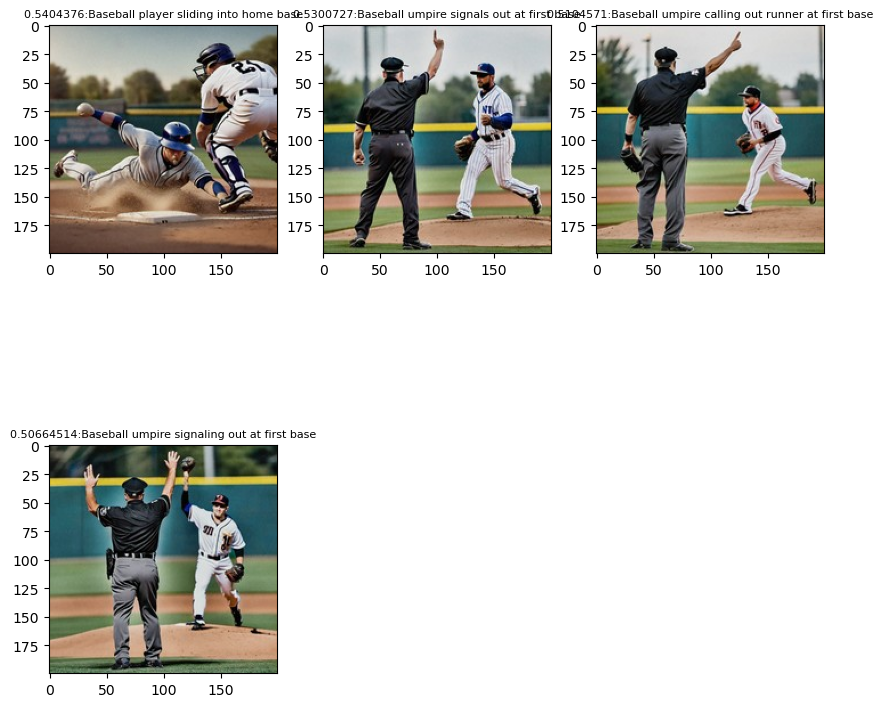

In [23]:
#optional_description = "celebrate victory" # this can be user supplied text in addition to the image
optional_description = "sliding into base"
#optional_description = "diving catch"
query_emb = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
results_semantic_img_filter = query_similarity_filter(query_emb,filter_text=optional_description, hits=10, k=2)
display_results(results_semantic_img_filter, df_metadata)

### Hybrid search using Rank Fusion

With non serverless deployment of Amazon OpenSearch service using features released in September 2023 as part of OpenSearch 2.10, you can do that relatively easily using a "search pipeline" that includes a normalization processor. The pipeline runs at search time and normalizes the scores to a common scale, enabling meaningful combination. The process involves using min-max normalization and harmonic mean as the normalization and combination techniques, respectively. Additionally, the weights assigned to the query clauses can be adjusted to balance the influence of lexical and semantic search.

Amazon OpenSearch Serverless does not support this feature yet so you need to develop the feature outside of Opensearch for the moment.

Same for other vectorDBs including Amazon RDS for PostgreSQL using pgvector for example.


#### RFF - Reciprocal Rank Fusion
There are various strategies and algorithm to merge 2 lists of results.

The Reciprocal Rank Fusion (RRF) is a sophisticated algorithm that combines different sets of results, each with its own relevance scores, into a single unified set of results. One of the main benefits of RRF is that it can produce high-quality results without requiring any adjustments or tuning. Additionally, RRF does not require the relevance scores from different sources to be related or similar in nature.

How does it work?

The Reciprocal Rank Fusion (RRF) technique works by gathering search results from multiple different approaches, assigning each document in the results a score based on its reciprocal rank, and then combining these scores to produce a new ranking. The core idea behind this method is that documents that consistently appear at higher ranks across various search strategies are more likely to be relevant, and therefore, should receive a higher ranking in the consolidated search result.

Algorithm explained here: https://www.elastic.co/guide/en/elasticsearch/reference/current/rrf.html

In [71]:
# RFF method 

#merge 2 lists of movies and remove duplicates
def merge_remove_duplicates(list1, list2):
    # Create an empty dictionary to store unique entries
    unique_entries = {}

    # Iterate over the first list
    for entry in list1:
        image_id = entry['image_id']
        unique_entries[image_id] = entry

    # Iterate over the second list
    for entry in list2:
        image_id = entry['image_id']
        if image_id not in unique_entries:
            unique_entries[image_id] = entry

    # Convert the dictionary back to a list
    merged_list = list(unique_entries.values())

    return merged_list


def reciprocal_rank_fusion(list1, list2):
    # Create a dictionary to store ranks
    ranks = {}

    max_size = max(len(list1), len(list2))
    
    # Assign ranks to items in list1
    for rank, item in enumerate(list1, start=1):
        image_id = item['image_id']
        ranks.setdefault(image_id, []).append(rank)
    
    # Assign ranks to items in list2
    for rank, item in enumerate(list2, start=1):
        image_id = item['image_id']
        ranks.setdefault(image_id, []).append(rank)
    
    #ranks will look like: {'168259': [1, 5], '460846': [2, 12], '294254': [3]}
    
    # Calculate RRF scores
    # example: for '168259': [1, 5], the RFF score is 1/1 + 1/5 = 1.2
    rrf_scores = {}
    for image_id, ranks_list in ranks.items():
        rrf_score = sum(1 / rank for rank in ranks_list)
        rrf_scores[image_id] = rrf_score
    
    merged_list = merge_remove_duplicates(list1, list2)
    for item in merged_list:
        image_id = item['image_id']
        item['RFF_score'] = rrf_scores.get(image_id, 0)

    sorted_merged_list = sorted(merged_list, key=lambda x: x['RFF_score'], reverse=True)

    return sorted_merged_list[:max_size]

def format_rrf_search_result(res):
    formatted_results = []
    
    for hit in res["hits"]["hits"]:
        item = {
            "image_id":hit["_source"]["image_id"],
            "path":hit["_source"]["image_url"],
            "title":hit["_source"]["title"]
        }
        formatted_results.append(item)
    
    return formatted_results

def display_rrf_results(results, dataset):
    images = []
    for item in results:
        image_id = item["image_id"]
        image, item_name = get_image_from_item_id(image_id = image_id, dataset = dataset,image_path = None)
        image.name_and_score = "{} : {}".format(item["RFF_score"],item["title"])
        images.append(image)
    display_images(images)
        

The following cell runs a lexical search and a semantic search using a reference image as well as the search term

In [72]:
#  set the search term 
search_term = "diving to catch the ball"

# lexical search
results_lexical = query_text_description(search_term, 5)
# semantic search 
query_emb = get_titan_multimodal_embedding(image_path=path, description=search_term, dimension=1024)["embedding"]
#query_emb = get_titan_multimodal_embedding(description=search_term, dimension=1024)["embedding"]
results_semantic_text = query_similarity(query_emb, hits=5, k=2)
results_semantic_img_txt = query_similarity(query_emb, hits=10, k=2)

Combining the two results using Reciprocal rank fusion 

In [73]:
#---------- Hybrid search fusion with RRF -----------
RFF_response  = reciprocal_rank_fusion(format_rrf_search_result(results_lexical), format_rrf_search_result(results_semantic_img_txt))

Display the result of the RRF algorithm 

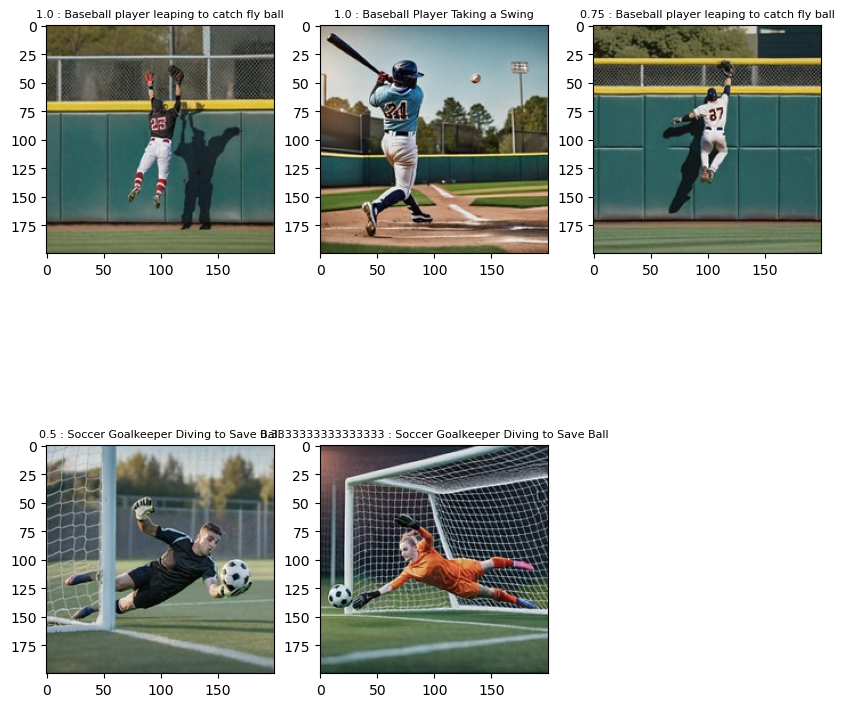

In [74]:
display_rrf_results(RFF_response, df_metadata)

# Advanced RAG with fusion and decomposition 

Fusion in RAG presents an innovative search strategy designed to transcend the limitations of conventional search techniques, aligning more closely with the complex nature of human inquiries. This initiative elevates the search experience by integrating multi-faceted query generation and using Reciprocal Rank Fusion for an enhanced re-ranking of search outcomes. This approach offers a more nuanced and effective way to navigate the vast expanse of available information, catering to the intricate and varied demands of users’ searches.

The following diagram illustrates this flow. 

![Alt text](./static/mmrag-query-ranking.png "Adanced Rag with Fusion and Decomposition")



## Evaluation of the search results

Evaluation of search results requires ground truth results. In real life world we would have a search term and associated best results in the right ranking order. Since this is a lab and we have no set results, we are going to utilise an LLM as a judge to reorder images for a given search term as best as possible based on its reasoning capabilities. 

Since Claude Sonnet 3.5 has state of the art reasoning capabilities, we are going to define a prompt to reorder a static list of media assets based on its text description (which we generated utilising Sonnet in data prep lab). Due to the non deterministic nature of LLMs the final order of the ground truth dataset generated may vary from run to run. 

The rearranged list of media assets returned will used as ground truth for subsquent evaluation algorithms in this lab.

The following cell defines some helper functions to carry out dataframe to json transformation to be passed as context to the Claude. Additionally, we also have a list of search terms that we will be utilising for evaluation purposes. In this example we have 3 different search terms all related to baseball. 

In [63]:
# helper functions 

search_terms_eval_list = [
    "diving to catch the ball",
    "sliding into base",
    "celebrating victory"
]

#model_id = "anthropic.claude-3-haiku-20240307-v1:0"
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
bedrock_client = boto3.client('bedrock-runtime')

def df_to_json(df):
    json_list = []
    
    for _, row in df.iterrows():
        json_dict = row.to_dict()
        json_list.append(json_dict)
    
    return json_list

def rearrange_list(bedrock_client, model_id, prompt, max_tokens,top_p,temp):
    message_mm = [
        { "role": "user",
          "content": [
              {"type": "text","text": prompt}
          ]
        }
    ]
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": message_mm,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = bedrock_client.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]
    return response_text

def format_search_result(res):
    formatted_results = []
    
    for hit in res["hits"]["hits"]:
        item = {
            "image_id":hit["_source"]["image_id"],
            "path":hit["_source"]["image_url"],
            "title":hit["_source"]["title"]
        }
        formatted_results.append(item)
    
    df = pd.DataFrame(formatted_results)
    return df

The following cell filters all baseball related images from the dataframe based on the keyword field. This is done to work with a base list of all baseball images which we can reorder using another term (e.g. catching, diving). 

In [64]:
# first filter to get all image descriptions the contain baseball
df_subset = df_metadata[df_metadata["keywords"].str.contains("baseball")]
print("found {0} number of images post filter".format(df_subset.shape[0]))


found 58 number of images post filter


In [65]:
df_subset = df_subset.drop(columns=["embeddings"]) # drop the embeddings
df_subset.head()

image_id                                        path  \
0  00a7655d4eabf186.jpg  ./data/resized-images/00a7655d4eabf186.jpg   
1  19aa926f2f7d9782.jpg  ./data/resized-images/19aa926f2f7d9782.jpg   
2  39209fa476d1430c.jpg  ./data/resized-images/39209fa476d1430c.jpg   
3  1efc2db85591a04f.jpg  ./data/resized-images/1efc2db85591a04f.jpg   
4  3c06d149c8027e71.jpg  ./data/resized-images/3c06d149c8027e71.jpg   

                                   title  \
0  Baseball player batting during a game   
1  Baseball Player Batting During a Game   
2     Baseball Players Gathered on Field   
3          Baseball batter at home plate   
4          Youth Baseball Player Batting   

                                         description  \
0  The image depicts a baseball player in a batti...   
1  The image depicts a professional baseball play...   
2  The image depicts a group of baseball players ...   
3  The image depicts a baseball game in progress....   
4  The image depicts a young baseball player in a...   

                                            keywords  \
0  baseball, sports, batting, player, jersey, sta...   
1  baseball, sports, athlete, batting, swing, sta...   
2  baseball, players, team, field, uniforms, bats...   
3  baseball, batter, swing, pitch, catcher, field...   
4  baseball, youth sports, batting, swing, athlet...   

                                                tags  
0     baseball, sports, athlete, action, competition  
1  baseball, sports, athlete, batting, stadium, g...  
2  sports, baseball, athletes, coaching, team gat...  
3       baseball, sports, game, athlete, competition  
4          sports, baseball, youth, athlete, batting

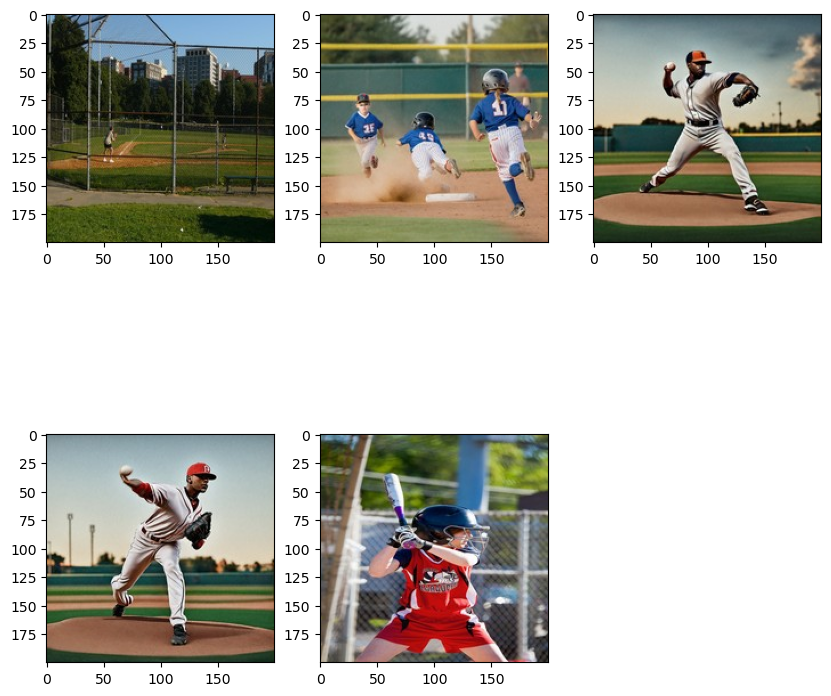

In [66]:
# preview the set of images found to verify visually 
images = []
for idx, item in df_subset.sample(5).iterrows():
    img = Image.open(item['path'])
    images.append(img)

display_images(images)

In [67]:
# get Claude to rearrange and reorder the list - pushing photos with actual diving catch to higher rank
prompt = """
Your task is to rearrange and rank a json payload containing a list of various images alongside their relevant metadata  such as image_id, path, title, description, keywords, and tags per image. 
The input list is provided in the <list> xml tags.
The image_id field in the list contains the filename for the image. 

The rearranging and ranking must be done based on topic contained in the <topic> xml tags by carefully reviewing the topic against provided metadata and ascertain relevance. 
first item in the list should be the most relevant to the topic, then second and so forth. 

<topic>{term}</topic>

<list> 
{images} 
</list> 

Important: Rearrange the list provided in the <list> XML tag only and do not fabricate any new data and do not exclude any images in the output. 
Return a valid json array in the output as specified in the <example> xml tag. Only image_id, path and title fields are required in the output. 
Do not include XML tags in the output. 
return only {k} number of items in the outout

<example>
[{"image_id":"1efc2db85591a04f.jpg","path":"./data/curated-images/1efc2db85591a04f.jpg","title":"Baseball batter at home plate"}]
</example>

[

"""


In [68]:
# get a rearranged list using Claude as the judge based on the description for each image.
subset_json = df_to_json(df_subset)
formated_system_prompt = prompt.replace("{term}", search_terms_eval_list[0]).replace("{images}", str(subset_json)).replace("{k}",str(10))
rearranged_list = rearrange_list(bedrock_client, model_id = model_id, prompt=formated_system_prompt, max_tokens=4000, temp=0.1, top_p=0.9)
df_rearranged = pd.DataFrame(json.loads(rearranged_list))
df_rearranged.head()


image_id                                        path  \
0  93ad2f5f7762bc42.jpg  ./data/resized-images/93ad2f5f7762bc42.jpg   
1  1efc2db85591a04f.jpg  ./data/resized-images/1efc2db85591a04f.jpg   
2  00a7655d4eabf186.jpg  ./data/resized-images/00a7655d4eabf186.jpg   
3  19aa926f2f7d9782.jpg  ./data/resized-images/19aa926f2f7d9782.jpg   
4  3aa0e7de9aa1d4b7.jpg  ./data/resized-images/3aa0e7de9aa1d4b7.jpg   

                                   title  
0         Baseball batter taking a swing  
1          Baseball batter at home plate  
2  Baseball player batting during a game  
3  Baseball Player Batting During a Game  
4       Baseball player batting on field

#### Preparing the evaluation dataset

Prepare set of search results to be evaluated including generation of ground truth using Claude. We will be conducting a series of search using 3 terms from the search_terms_eval list variable. The following cell carries this out by. 

- Iterate over the search terms list 
- for each term invoke a semantic search for image + optional text, generated text + optional text, and lastly image + k-NN filter
- for each term generate ground truth using Claude (since we do not have real data) 
- prepare a single variable holding all result sets for calculation of evaluation metrics. This case we are preparing a dictionary object with all results.

In [75]:
# prepare set of search results to be evaluated including generation of ground truth

test_img_emb = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
search_results = dict()
counter = 1

for term in search_terms_eval_list: 
    
    # lexical search 
    results_lexical = query_text_description(term, 10)

    # image + text 
    query_emb = get_titan_multimodal_embedding(image_path=path, description=term, dimension=1024)["embedding"]
    results_semantic_img_txt = query_similarity(query_emb, hits=10, k=2)
    
    # gen text + text 
    search_term = res + term
    query_emb = get_titan_multimodal_embedding(description=search_term, dimension=1024)["embedding"]
    results_semantic_gen_text = query_similarity(query_emb, hits=10, k=2)
    
    # image + filter
    results_semantic_img_filter = query_similarity_filter(test_img_emb,filter_text=term, hits=10, k=2)

    # RRF ranking (combine lexical + image + text)
    results_rrf = reciprocal_rank_fusion(format_rrf_search_result(results_lexical), format_rrf_search_result(results_semantic_img_txt))
    df_results_rrf = pd.DataFrame(results_rrf)

    # generate ground truth 
    formated_system_prompt = prompt.replace("{term}", term).replace("{images}", str(subset_json)).replace("{k}",str(10))
    rearranged_list = rearrange_list(bedrock_client, model_id = model_id, prompt=formated_system_prompt, max_tokens=4000, temp=0.1, top_p=0.9)
    df_groundtruth = pd.DataFrame(json.loads(rearranged_list))

    payload = {
        "lexical":format_search_result(results_lexical),
        "semantic_img_txt":format_search_result(results_semantic_img_txt),
        "semantic_gen_txt":format_search_result(results_semantic_gen_text),
        "semantic_img_filter":format_search_result(results_semantic_img_filter),
        "rrf":df_results_rrf,
        "ground_truth":df_groundtruth
    }
    
    search_results["term{}".format(counter)] = payload
    counter += 1


In [76]:
# review the results set quickly
df = search_results["term3"]["ground_truth"].head()
df.head()

image_id  \
0                      5014cc45d81322b8.jpg   
1  fe998796-2fc9-4c06-b650-c71047d7acc1.jpg   
2                      93ad2f5f7762bc42.jpg   
3                      1efc2db85591a04f.jpg   
4                      00a7655d4eabf186.jpg   

                                                path  \
0         ./data/resized-images/5014cc45d81322b8.jpg   
1  ./data/resized-images/fe998796-2fc9-4c06-b650-...   
2         ./data/resized-images/93ad2f5f7762bc42.jpg   
3         ./data/resized-images/1efc2db85591a04f.jpg   
4         ./data/resized-images/00a7655d4eabf186.jpg   

                                               title  
0  Baseball player leaping to celebrate after sco...  
1            Baseball Team Celebrating After Scoring  
2                     Baseball batter taking a swing  
3                      Baseball batter at home plate  
4              Baseball player batting during a game

### Precision
To calculate the precision of a search result, we need to determine the ratio of relevant items in the list to be evaluated compared to the total number of items in that list.

In [77]:
# precision = count of matched rows / total number of results

def calculate_precision(results, results_key="semantic_img_txt"):
    precision_results = []
    for key, item in results.items():
        total_matches = pd.merge(item["ground_truth"], item[results_key], how="inner", on=['image_id']).shape[0]
        total_items = item[results_key].shape[0]
        precision_results.append(total_matches / total_items)
        #print("found {0} of matches out of {1}".format(total_matches, total_items))
    return sum(precision_results)/len(precision_results)

In [78]:
precision_img_txt = calculate_precision(search_results,"semantic_img_txt")
precision_gen_txt = calculate_precision(search_results,"semantic_gen_txt")
precision_img_filter = calculate_precision(search_results,"semantic_img_filter")
precision_lexical = calculate_precision(search_results,"lexical")
precision_rrf = calculate_precision(search_results,"rrf")

In [79]:
print("Scenario: baseball player image with accompanying terms")
print("Precision for lexical: {}%".format(precision_lexical*100))
print("Precision for semantic search with Image Embedding and Text Search Term: {}%".format(precision_img_txt*100))
print("Precision for semantic search with Generated Text & Text Search Term: {}%".format(precision_gen_txt*100))
print("Precision for semantic search with Image Embedding and k-NN Filter: {}%".format(precision_img_filter*100))
print("Precision for RRF: {}%".format(precision_rrf*100))

Scenario: baseball player image with accompanying terms
Precision for lexical: 33.05555555555556%
Precision for semantic search with Image Embedding and Text Search Term: 50.0%
Precision for semantic search with Generated Text & Text Search Term: 33.33333333333333%
Precision for semantic search with Image Embedding and k-NN Filter: 41.66666666666667%
Precision for RRF: 41.111111111111114%


### Mean Reciprocal Rank (MRR)
The Mean Reciprocal Rank (MRR) is a metric used to evaluate the performance of a ranking system, such as a search engine or a recommendation system. It measures the average reciprocal rank of the first relevant item in the ranked list.

Here's how the MRR algorithm works:

1. For each query (or search term), we have a list of relevant items and a list of items to be evaluated (the ranked list returned by the system).
2. We iterate through the ranked list and find the position (rank) of the first relevant item.
3. If no relevant item is found, the reciprocal rank is considered 0.
4. Otherwise, the reciprocal rank is calculated as 1 / rank, where rank is the position of the first relevant item.
5. The MRR is the average of the reciprocal ranks across all queries.

A higher MRR value indicates better ranking performance, with a maximum value of 1 when the first item in the ranked list is always relevant.

In [80]:
def calculate_mrr(results, results_key="semantic_img_txt"):
    
    total_queries = len(results)
    reciprocal_ranks = []
    
    for key, item in results.items():
        df_ground = item["ground_truth"]
        df_results = item[results_key]
        matched_rows = pd.merge(df_ground, df_results, how="inner", on=['image_id'])
        # position of the first matched row - rank
        # if matched_rows contains records then else set to 0
        if matched_rows.shape[0] > 0: 
            rank = df_results[df_results["image_id"] == matched_rows.loc[0,"image_id"]].index[0] + 1
            reciprocal_ranks.append(1 / rank)
        else: 
            reciprocal_ranks.append(0)

    mrr = sum(reciprocal_ranks) / total_queries

    return mrr

In [81]:
mrr_lexical = calculate_mrr(search_results,"lexical")
mrr_img_txt = calculate_mrr(search_results,"semantic_img_txt")
mrr_gen_txt = calculate_mrr(search_results,"semantic_gen_txt")
mrr_img_filter = calculate_mrr(search_results,"semantic_img_filter")
mrr_rrf = calculate_mrr(search_results,"rrf")

In [82]:
print("Scenario: baseball player image with accompanying terms")
print("MRR for lexical search: {}".format(mrr_lexical))
print("MRR for semantic search with Image Embedding and Text Search Term: {}".format(mrr_img_txt))
print("MRR for semantic search with Generated Text & Text Search Term: {}".format(mrr_gen_txt))
print("MRR for semantic search with Image Embedding and k-NN Filter: {}".format(mrr_img_filter))
print("MRR for RRF search: {}".format(mrr_rrf))

Scenario: baseball player image with accompanying terms
MRR for lexical search: 0.27777777777777773
MRR for semantic search with Image Embedding and Text Search Term: 0.611111111111111
MRR for semantic search with Generated Text & Text Search Term: 0.19444444444444442
MRR for semantic search with Image Embedding and k-NN Filter: 0.8333333333333334
MRR for RRF search: 0.2888888888888889


## Conclusion

In general we notice that lexical search returns superior results if we enrich the dataset with accurate and extensive metadata. In our case this is evident when we utilise Claude to extract text metadata from a source image and utilise that for embeddings search.

However, for relevancy especially when combining multi-modality (image + text) lexical search tends to suffer in both accuracy and relevancy. For this purposes we recommend leveraging Hybrid approaches to boost relevancy. There are several options present to carry this out from using k-NN filters, reciprocal rank fusion to using RAG fusions 